In [1]:
# Title: DMRG for Bachelor Thesis
# Author: Aaron Sander
# Date: March-April 2020

# This program is used for initial learning of tensor network methods
# to be used in my bachelor thesis.
# It is an implementation of Matrix Product States (MPS) and Density Matrix
# Renormalization Group (DMRG) for compressing an arbitrary quantum state
# which has relevant applications in data compression and graph embedding.

### NOTE: This code is written for learning purposes. It is not meant
###       to be optimized for speed/efficiency, but has readability in mind.

In [2]:
######################### IMPORTS #############################################
from benchmarks import *
from canonical_forms import *
from classes import *
from compression import *
from contractions import *
from initializations import *
from metrics import *

# Compression

The following generates a list of possible Matrix Product States with maximum bond dimensions up to that of the raw data.

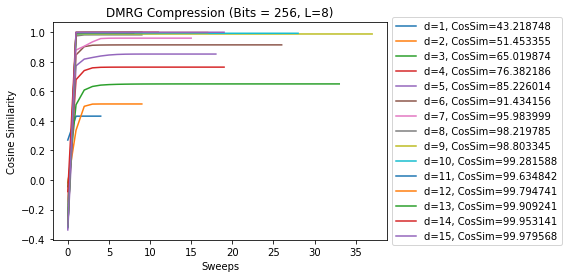

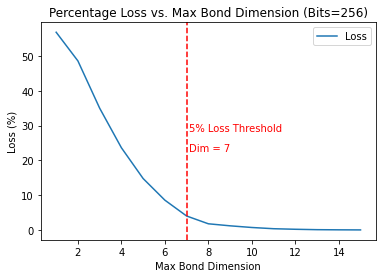

In [3]:
# Physical dimension
d = 2
data = rawData(bits=256, phys_dim=d)
compressed_data = compressedData(data.MPS, phys_dim=d)

# DMRG

In [4]:
L = 5
d = 2

In [23]:
MPS = randomState(num_sites=L, max_bond_dim=20, phys_dim=d).MPS
MPO = initialize_quantum_ising(num_particles = L)

In [24]:
TN = Network(MPS, MPO, MPS)

In [25]:
TN.expectation_value

9.883376968139647